In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import time
import numpy as np
from torch.autograd.variable import Variable
from torchvision import transforms
from matplotlib.patches import Circle
import os
import numpy.random as npr
import matplotlib.pyplot as plt

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Dataset/Wider_face_train/WIDER_val.zip' -d '/content'




1.   Dataset: https://drive.google.com/file/d/1lrRfk_WA7rMbRehVLXLg8xzAaSsmPc2y/view?usp=sharing
2.   Annotation: https://drive.google.com/file/d/1Obm8DC0E0HqLiQtUGpiX8z8ZEM3nB3pD/view?usp=sharing
3.   Pretrained weights: https://drive.google.com/file/d/1H7dxZQMdDAIXgTSPR_ZGSot3DIgTObcm/view?usp=sharing
4.   Reference: https://github.com/kuaikuaikim/DFace



# **Model**

In [4]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    nn.init.xavier_uniform(m.weight.data)
    nn.init.constant(m.bias, 0.1)

In [5]:
class PNet(nn.Module):
    ''' PNet '''

    def __init__(self, is_train=False, use_cuda=True):
        super(PNet, self).__init__()
        self.is_train = is_train
        self.use_cuda = use_cuda

        # backend
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # PReLU1
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool1
            nn.Conv2d(10, 16, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # PReLU2
            nn.Conv2d(16, 32, kernel_size=3, stride=1),  # conv3
            nn.PReLU()  # PReLU3
        )
        # detection
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        # bounding box regresion
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        # landmark localization
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)

        # weight initiation with xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        label = F.sigmoid(self.conv4_1(x))
        offset = self.conv4_2(x)
        # landmark = self.conv4_3(x)

        if self.is_train is True:
            # label_loss = LossUtil.label_loss(self.gt_label,torch.squeeze(label))
            # bbox_loss = LossUtil.bbox_loss(self.gt_bbox,torch.squeeze(offset))
            return label,offset
        #landmark = self.conv4_3(x)
        return label, offset


class RNet(nn.Module):
    ''' RNet '''

    def __init__(self,is_train=False, use_cuda=True):
        super(RNet, self).__init__()
        self.is_train = is_train
        self.use_cuda = use_cuda
        # backend
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            nn.Conv2d(28, 48, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(48, 64, kernel_size=2, stride=1),  # conv3
            nn.PReLU()  # prelu3

        )
        self.conv4 = nn.Linear(64*2*2, 128)  # conv4
        self.prelu4 = nn.PReLU()  # prelu4
        # detection
        self.conv5_1 = nn.Linear(128, 1)
        # bounding box regression
        self.conv5_2 = nn.Linear(128, 4)
        # lanbmark localization
        self.conv5_3 = nn.Linear(128, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        # backend
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        # detection
        det = torch.sigmoid(self.conv5_1(x))
        box = self.conv5_2(x)
        # landmark = self.conv5_3(x)

        if self.is_train is True:
            return det, box
        #landmard = self.conv5_3(x)
        return det, box


class ONet(nn.Module):
    ''' RNet '''

    def __init__(self,is_train=False, use_cuda=True):
        super(ONet, self).__init__()
        self.is_train = is_train
        self.use_cuda = use_cuda
        # backend
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            nn.Conv2d(32, 64, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # conv3
            nn.PReLU(), # prelu3
            nn.MaxPool2d(kernel_size=2,stride=2), # pool3
            nn.Conv2d(64,128,kernel_size=2,stride=1), # conv4
            nn.PReLU() # prelu4
        )
        self.conv5 = nn.Linear(128*2*2, 256)  # conv5
        self.prelu5 = nn.PReLU()  # prelu5
        # detection
        self.conv6_1 = nn.Linear(256, 1)
        # bounding box regression
        self.conv6_2 = nn.Linear(256, 4)
        # lanbmark localization
        self.conv6_3 = nn.Linear(256, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        # backend
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        # detection
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        if self.is_train is True:
            return det, box, landmark
        #landmard = self.conv5_3(x)
        return det, box, landmark

# **Loss Function**

In [6]:
class LossFn:
    def __init__(self, cls_factor=1, box_factor=1, landmark_factor=1):
        # loss function
        self.cls_factor = cls_factor
        self.box_factor = box_factor
        self.land_factor = landmark_factor
        self.loss_cls = nn.BCELoss()
        self.loss_box = nn.MSELoss()
        self.loss_landmark = nn.MSELoss()


    def cls_loss(self,gt_label,pred_label):
        pred_label = torch.squeeze(pred_label)
        gt_label = torch.squeeze(gt_label)
        # get the mask element which >= 0, only 0 and 1 can effect the detection loss
        mask = torch.ge(gt_label,0)
        valid_gt_label = torch.masked_select(gt_label,mask)
        valid_pred_label = torch.masked_select(pred_label,mask)
        return self.loss_cls(valid_pred_label,valid_gt_label)*self.cls_factor


    def box_loss(self,gt_label,gt_offset,pred_offset):
        pred_offset = torch.squeeze(pred_offset)
        gt_offset = torch.squeeze(gt_offset)
        gt_label = torch.squeeze(gt_label)

        #get the mask element which != 0
        unmask = torch.eq(gt_label,0)
        mask = torch.eq(unmask,0)
        #convert mask to dim index
        chose_index = torch.nonzero(mask.data)
        chose_index = torch.squeeze(chose_index)
        #only valid element can effect the loss
        valid_gt_offset = gt_offset[chose_index,:]
        valid_pred_offset = pred_offset[chose_index,:]
        return self.loss_box(valid_pred_offset,valid_gt_offset)*self.box_factor


    def landmark_loss(self,gt_label,gt_landmark,pred_landmark):
        pred_landmark = torch.squeeze(pred_landmark)
        gt_landmark = torch.squeeze(gt_landmark)
        gt_label = torch.squeeze(gt_label)
        mask = torch.eq(gt_label,-2)

        chose_index = torch.nonzero(mask.data)
        chose_index = torch.squeeze(chose_index)

        valid_gt_landmark = gt_landmark[chose_index, :]
        valid_pred_landmark = pred_landmark[chose_index, :]
        return self.loss_landmark(valid_pred_landmark,valid_gt_landmark)*self.land_factor

# **Image Tool & Ultils**

In [7]:
transform = transforms.ToTensor()

def convert_image_to_tensor(image):
    """convert an image to pytorch tensor
        Parameters:
        ----------
        image: numpy array , h * w * c
        Returns:
        -------
        image_tensor: pytorch.FloatTensor, c * h * w
        """
    image = image.astype(np.float)
    return (transform(image) / 255).float()
    # return transform(image)


def convert_chwTensor_to_hwcNumpy(tensor):
    """convert a group images pytorch tensor(count * c * h * w) to numpy array images(count * h * w * c)
            Parameters:
            ----------
            tensor: numpy array , count * c * h * w
            Returns:
            -------
            numpy array images: count * h * w * c
            """

    if isinstance(tensor, Variable):
        return np.transpose(tensor.data.numpy(), (0,2,3,1))
    elif isinstance(tensor, torch.FloatTensor):
        return np.transpose(tensor.numpy(), (0,2,3,1))
    else:
        raise Exception("covert b*c*h*w tensor to b*h*w*c numpy error.This tensor must have 4 dimension.")

In [8]:
def IoU(box, boxes):
    """Compute IoU between detect box and gt boxes
    Parameters:
    ----------
    box: numpy array , shape (5, ): x1, y1, x2, y2, score
        input box
    boxes: numpy array, shape (n, 4): x1, y1, x2, y2
        input ground truth boxes
    Returns:
    -------
    ovr: numpy.array, shape (n, )
        IoU
    """
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = np.true_divide(inter,(box_area + area - inter))
    #ovr = inter / (box_area + area - inter)
    return ovr


def convert_to_square(bbox):
    """Convert bbox to square
    Parameters:
    ----------
    bbox: numpy array , shape n x 5
        input bbox
    Returns:
    -------
    square bbox
    """
    square_bbox = bbox.copy()

    h = bbox[:, 3] - bbox[:, 1] + 1
    w = bbox[:, 2] - bbox[:, 0] + 1
    max_side = np.maximum(h,w)
    square_bbox[:, 0] = bbox[:, 0] + w*0.5 - max_side*0.5
    square_bbox[:, 1] = bbox[:, 1] + h*0.5 - max_side*0.5
    square_bbox[:, 2] = square_bbox[:, 0] + max_side - 1
    square_bbox[:, 3] = square_bbox[:, 1] + max_side - 1
    return square_bbox


def nms(dets, thresh, mode="Union"):
    """
    greedily select boxes with high confidence
    keep boxes overlap <= thresh
    rule out overlap > thresh
    :param dets: [[x1, y1, x2, y2 score]]
    :param thresh: retain overlap <= thresh
    :return: indexes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        if mode == "Union":
            ovr = inter / (areas[i] + areas[order[1:]] - inter)
        elif mode == "Minimum":
            ovr = inter / np.minimum(areas[i], areas[order[1:]])

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep


# **Detect**

In [9]:
def create_mtcnn_net(p_model_path=None, r_model_path=None, o_model_path=None, use_cuda=True):

    pnet, rnet, onet = None, None, None

    if p_model_path is not None:
        pnet = PNet(use_cuda=use_cuda)       
        if(use_cuda):
            pnet.load_state_dict(torch.load(p_model_path))
            pnet.cuda()
        else:
            # forcing all GPU tensors to be in CPU while loading
            pnet.load_state_dict(torch.load(p_model_path, map_location=lambda storage, loc: storage))
        pnet.eval()

    if r_model_path is not None:
        rnet = RNet(use_cuda=use_cuda)
        if (use_cuda):
            rnet.load_state_dict(torch.load(r_model_path))
            rnet.cuda()
        else:
            rnet.load_state_dict(torch.load(r_model_path, map_location=lambda storage, loc: storage))
        rnet.eval()

    if o_model_path is not None:
        onet = ONet(use_cuda=use_cuda)
        if (use_cuda):
            onet.load_state_dict(torch.load(o_model_path))
            onet.cuda()
        else:
            onet.load_state_dict(torch.load(o_model_path, map_location=lambda storage, loc: storage))
        onet.eval()
        
    return pnet,rnet,onet

In [10]:
class MtcnnDetector(object):
    """
        P,R,O net face detection and landmarks align
    """
    def __init__(self,
                 pnet = None,
                 rnet = None,
                 onet = None,
                 min_face_size=12,
                 stride=2,
                 threshold=[0.6, 0.7, 0.7],
                 scale_factor=0.709,
                 ):

        self.pnet_detector = pnet
        self.rnet_detector = rnet
        self.onet_detector = onet
        self.min_face_size = min_face_size
        self.stride=stride
        self.thresh = threshold
        self.scale_factor = scale_factor


    def unique_image_format(self,im):
        if not isinstance(im,np.ndarray):
            if im.mode == 'I':
                im = np.array(im, np.int32, copy=False)
            elif im.mode == 'I;16':
                im = np.array(im, np.int16, copy=False)
            else:
                im = np.asarray(im)
        return im

    def square_bbox(self, bbox):
        """
            convert bbox to square
        Parameters:
        ----------
            bbox: numpy array , shape n x m
                input bbox
        Returns:
        -------
            square bbox
        """
        square_bbox = bbox.copy()

        h = bbox[:, 3] - bbox[:, 1] + 1
        w = bbox[:, 2] - bbox[:, 0] + 1
        l = np.maximum(h,w)
        square_bbox[:, 0] = bbox[:, 0] + w*0.5 - l*0.5
        square_bbox[:, 1] = bbox[:, 1] + h*0.5 - l*0.5

        square_bbox[:, 2] = square_bbox[:, 0] + l - 1
        square_bbox[:, 3] = square_bbox[:, 1] + l - 1
        return square_bbox


    def generate_bounding_box(self, map, reg, scale, threshold):
        """
            generate bbox from feature map
        Parameters:
        ----------
            map: numpy array , n x m x 1
                detect score for each position
            reg: numpy array , n x m x 4
                bbox
            scale: float number
                scale of this detection
            threshold: float number
                detect threshold
        Returns:
        -------
            bbox array
        """
        stride = 2
        cellsize = 12

        t_index = np.where(map > threshold)

        # find nothing
        if t_index[0].size == 0:
            return np.array([])

        dx1, dy1, dx2, dy2 = [reg[0, t_index[0], t_index[1], i] for i in range(4)]
        reg = np.array([dx1, dy1, dx2, dy2])

        # lefteye_dx, lefteye_dy, righteye_dx, righteye_dy, nose_dx, nose_dy, \
        # leftmouth_dx, leftmouth_dy, rightmouth_dx, rightmouth_dy = [landmarks[0, t_index[0], t_index[1], i] for i in range(10)]
        #
        # landmarks = np.array([lefteye_dx, lefteye_dy, righteye_dx, righteye_dy, nose_dx, nose_dy, leftmouth_dx, leftmouth_dy, rightmouth_dx, rightmouth_dy])



        score = map[t_index[0], t_index[1], 0]
        boundingbox = np.vstack([np.round((stride * t_index[1]) / scale),
                                 np.round((stride * t_index[0]) / scale),
                                 np.round((stride * t_index[1] + cellsize) / scale),
                                 np.round((stride * t_index[0] + cellsize) / scale),
                                 score,
                                 reg,
                                 # landmarks
                                 ])

        return boundingbox.T


    def resize_image(self, img, scale):
        """
            resize image and transform dimention to [batchsize, channel, height, width]
        Parameters:
        ----------
            img: numpy array , height x width x channel
                input image, channels in BGR order here
            scale: float number
                scale factor of resize operation
        Returns:
        -------
            transformed image tensor , 1 x channel x height x width
        """
        height, width, channels = img.shape
        new_height = int(height * scale)     # resized new height
        new_width = int(width * scale)       # resized new width
        new_dim = (new_width, new_height)
        img_resized = cv2.resize(img, new_dim, interpolation=cv2.INTER_LINEAR)      # resized image
        return img_resized


    def pad(self, bboxes, w, h):
        """
            pad the the boxes
        Parameters:
        ----------
            bboxes: numpy array, n x 5
                input bboxes
            w: float number
                width of the input image
            h: float number
                height of the input image
        Returns :
        ------
            dy, dx : numpy array, n x 1
                start point of the bbox in target image
            edy, edx : numpy array, n x 1
                end point of the bbox in target image
            y, x : numpy array, n x 1
                start point of the bbox in original image
            ex, ex : numpy array, n x 1
                end point of the bbox in original image
            tmph, tmpw: numpy array, n x 1
                height and width of the bbox
        """

        tmpw = (bboxes[:, 2] - bboxes[:, 0] + 1).astype(np.int32)
        tmph = (bboxes[:, 3] - bboxes[:, 1] + 1).astype(np.int32)
        numbox = bboxes.shape[0]

        dx = np.zeros((numbox, ))
        dy = np.zeros((numbox, ))
        edx, edy  = tmpw.copy()-1, tmph.copy()-1

        x, y, ex, ey = bboxes[:, 0], bboxes[:, 1], bboxes[:, 2], bboxes[:, 3]

        tmp_index = np.where(ex > w-1)
        edx[tmp_index] = tmpw[tmp_index] + w - 2 - ex[tmp_index]
        ex[tmp_index] = w - 1

        tmp_index = np.where(ey > h-1)
        edy[tmp_index] = tmph[tmp_index] + h - 2 - ey[tmp_index]
        ey[tmp_index] = h - 1

        tmp_index = np.where(x < 0)
        dx[tmp_index] = 0 - x[tmp_index]
        x[tmp_index] = 0

        tmp_index = np.where(y < 0)
        dy[tmp_index] = 0 - y[tmp_index]
        y[tmp_index] = 0

        return_list = [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph]
        return_list = [item.astype(np.int32) for item in return_list]

        return return_list


    def detect_pnet(self, im):
        """Get face candidates through pnet
        Parameters:
        ----------
        im: numpy array
            input image array
        Returns:
        -------
        boxes: numpy array
            detected boxes before calibration
        boxes_align: numpy array
            boxes after calibration
        """

        # im = self.unique_image_format(im)

        h, w, c = im.shape
        net_size = 12

        current_scale = float(net_size) / self.min_face_size    # find initial scale
        im_resized = self.resize_image(im, current_scale)
        current_height, current_width, _ = im_resized.shape

        # fcn
        all_boxes = list()
        while min(current_height, current_width) > net_size:
            feed_imgs = []
            image_tensor = convert_image_to_tensor(im_resized)
            feed_imgs.append(image_tensor)
            feed_imgs = torch.stack(feed_imgs)
            feed_imgs = Variable(feed_imgs)


            if self.pnet_detector.use_cuda:
                feed_imgs = feed_imgs.cuda()

            cls_map, reg = self.pnet_detector(feed_imgs)

            cls_map_np = convert_chwTensor_to_hwcNumpy(cls_map.cpu())
            reg_np = convert_chwTensor_to_hwcNumpy(reg.cpu())
            # landmark_np = image_tools.convert_chwTensor_to_hwcNumpy(landmark.cpu())


            boxes = self.generate_bounding_box(cls_map_np[ 0, :, :], reg_np, current_scale, self.thresh[0])

            current_scale *= self.scale_factor
            im_resized = self.resize_image(im, current_scale)
            current_height, current_width, _ = im_resized.shape

            if boxes.size == 0:
                continue
            keep = nms(boxes[:, :5], 0.5, 'Union')
            boxes = boxes[keep]
            all_boxes.append(boxes)

        if len(all_boxes) == 0:
            return None, None

        all_boxes = np.vstack(all_boxes)

        # merge the detection from first stage
        keep = nms(all_boxes[:, 0:5], 0.7, 'Union')
        all_boxes = all_boxes[keep]
        # boxes = all_boxes[:, :5]

        bw = all_boxes[:, 2] - all_boxes[:, 0] + 1
        bh = all_boxes[:, 3] - all_boxes[:, 1] + 1

        # landmark_keep = all_boxes[:, 9:].reshape((5,2))


        boxes = np.vstack([all_boxes[:,0],
                   all_boxes[:,1],
                   all_boxes[:,2],
                   all_boxes[:,3],
                   all_boxes[:,4],
                   # all_boxes[:, 0] + all_boxes[:, 9] * bw,
                   # all_boxes[:, 1] + all_boxes[:,10] * bh,
                   # all_boxes[:, 0] + all_boxes[:, 11] * bw,
                   # all_boxes[:, 1] + all_boxes[:, 12] * bh,
                   # all_boxes[:, 0] + all_boxes[:, 13] * bw,
                   # all_boxes[:, 1] + all_boxes[:, 14] * bh,
                   # all_boxes[:, 0] + all_boxes[:, 15] * bw,
                   # all_boxes[:, 1] + all_boxes[:, 16] * bh,
                   # all_boxes[:, 0] + all_boxes[:, 17] * bw,
                   # all_boxes[:, 1] + all_boxes[:, 18] * bh
                  ])

        boxes = boxes.T

        align_topx = all_boxes[:, 0] + all_boxes[:, 5] * bw
        align_topy = all_boxes[:, 1] + all_boxes[:, 6] * bh
        align_bottomx = all_boxes[:, 2] + all_boxes[:, 7] * bw
        align_bottomy = all_boxes[:, 3] + all_boxes[:, 8] * bh

        # refine the boxes
        boxes_align = np.vstack([ align_topx,
                              align_topy,
                              align_bottomx,
                              align_bottomy,
                              all_boxes[:, 4],
                              # align_topx + all_boxes[:,9] * bw,
                              # align_topy + all_boxes[:,10] * bh,
                              # align_topx + all_boxes[:,11] * bw,
                              # align_topy + all_boxes[:,12] * bh,
                              # align_topx + all_boxes[:,13] * bw,
                              # align_topy + all_boxes[:,14] * bh,
                              # align_topx + all_boxes[:,15] * bw,
                              # align_topy + all_boxes[:,16] * bh,
                              # align_topx + all_boxes[:,17] * bw,
                              # align_topy + all_boxes[:,18] * bh,
                              ])
        boxes_align = boxes_align.T

        return boxes, boxes_align

    def detect_rnet(self, im, dets):
        """Get face candidates using rnet
        Parameters:
        ----------
        im: numpy array
            input image array
        dets: numpy array
            detection results of pnet
        Returns:
        -------
        boxes: numpy array
            detected boxes before calibration
        boxes_align: numpy array
            boxes after calibration
        """
        h, w, c = im.shape

        if dets is None:
            return None,None

        dets = self.square_bbox(dets)
        dets[:, 0:4] = np.round(dets[:, 0:4])

        [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = self.pad(dets, w, h)
        num_boxes = dets.shape[0]

        '''
        # helper for setting RNet batch size
        batch_size = self.rnet_detector.batch_size
        ratio = float(num_boxes) / batch_size
        if ratio > 3 or ratio < 0.3:
            print "You may need to reset RNet batch size if this info appears frequently, \
face candidates:%d, current batch_size:%d"%(num_boxes, batch_size)
        '''

        # cropped_ims_tensors = np.zeros((num_boxes, 3, 24, 24), dtype=np.float32)
        cropped_ims_tensors = []
        for i in range(num_boxes):
            tmp = np.zeros((tmph[i], tmpw[i], 3), dtype=np.uint8)
            tmp[dy[i]:edy[i]+1, dx[i]:edx[i]+1, :] = im[y[i]:ey[i]+1, x[i]:ex[i]+1, :]
            crop_im = cv2.resize(tmp, (24, 24))
            crop_im_tensor = convert_image_to_tensor(crop_im)
            # cropped_ims_tensors[i, :, :, :] = crop_im_tensor
            cropped_ims_tensors.append(crop_im_tensor)
        feed_imgs = Variable(torch.stack(cropped_ims_tensors))

        if self.rnet_detector.use_cuda:
            feed_imgs = feed_imgs.cuda()

        cls_map, reg = self.rnet_detector(feed_imgs)

        cls_map = cls_map.cpu().data.numpy()
        reg = reg.cpu().data.numpy()
        # landmark = landmark.cpu().data.numpy()


        keep_inds = np.where(cls_map > self.thresh[1])[0]

        if len(keep_inds) > 0:
            boxes = dets[keep_inds]
            cls = cls_map[keep_inds]
            reg = reg[keep_inds]
            # landmark = landmark[keep_inds]
        else:
            return None, None

        keep = nms(boxes, 0.7)

        if len(keep) == 0:
            return None, None

        keep_cls = cls[keep]
        keep_boxes = boxes[keep]
        keep_reg = reg[keep]
        # keep_landmark = landmark[keep]


        bw = keep_boxes[:, 2] - keep_boxes[:, 0] + 1
        bh = keep_boxes[:, 3] - keep_boxes[:, 1] + 1


        boxes = np.vstack([ keep_boxes[:,0],
                              keep_boxes[:,1],
                              keep_boxes[:,2],
                              keep_boxes[:,3],
                              keep_cls[:,0],
                              # keep_boxes[:,0] + keep_landmark[:, 0] * bw,
                              # keep_boxes[:,1] + keep_landmark[:, 1] * bh,
                              # keep_boxes[:,0] + keep_landmark[:, 2] * bw,
                              # keep_boxes[:,1] + keep_landmark[:, 3] * bh,
                              # keep_boxes[:,0] + keep_landmark[:, 4] * bw,
                              # keep_boxes[:,1] + keep_landmark[:, 5] * bh,
                              # keep_boxes[:,0] + keep_landmark[:, 6] * bw,
                              # keep_boxes[:,1] + keep_landmark[:, 7] * bh,
                              # keep_boxes[:,0] + keep_landmark[:, 8] * bw,
                              # keep_boxes[:,1] + keep_landmark[:, 9] * bh,
                            ])

        align_topx = keep_boxes[:,0] + keep_reg[:,0] * bw
        align_topy = keep_boxes[:,1] + keep_reg[:,1] * bh
        align_bottomx = keep_boxes[:,2] + keep_reg[:,2] * bw
        align_bottomy = keep_boxes[:,3] + keep_reg[:,3] * bh

        boxes_align = np.vstack([align_topx,
                               align_topy,
                               align_bottomx,
                               align_bottomy,
                               keep_cls[:, 0],
                               # align_topx + keep_landmark[:, 0] * bw,
                               # align_topy + keep_landmark[:, 1] * bh,
                               # align_topx + keep_landmark[:, 2] * bw,
                               # align_topy + keep_landmark[:, 3] * bh,
                               # align_topx + keep_landmark[:, 4] * bw,
                               # align_topy + keep_landmark[:, 5] * bh,
                               # align_topx + keep_landmark[:, 6] * bw,
                               # align_topy + keep_landmark[:, 7] * bh,
                               # align_topx + keep_landmark[:, 8] * bw,
                               # align_topy + keep_landmark[:, 9] * bh,
                             ])

        boxes = boxes.T
        boxes_align = boxes_align.T

        return boxes, boxes_align

    def detect_onet(self, im, dets):
        """Get face candidates using onet
        Parameters:
        ----------
        im: numpy array
            input image array
        dets: numpy array
            detection results of rnet
        Returns:
        -------
        boxes_align: numpy array
            boxes after calibration
        landmarks_align: numpy array
            landmarks after calibration
        """
        h, w, c = im.shape

        if dets is None:
            return None, None

        dets = self.square_bbox(dets)
        dets[:, 0:4] = np.round(dets[:, 0:4])

        [dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph] = self.pad(dets, w, h)
        num_boxes = dets.shape[0]


        # cropped_ims_tensors = np.zeros((num_boxes, 3, 24, 24), dtype=np.float32)
        cropped_ims_tensors = []
        for i in range(num_boxes):
            tmp = np.zeros((tmph[i], tmpw[i], 3), dtype=np.uint8)
            tmp[dy[i]:edy[i] + 1, dx[i]:edx[i] + 1, :] = im[y[i]:ey[i] + 1, x[i]:ex[i] + 1, :]
            crop_im = cv2.resize(tmp, (48, 48))
            crop_im_tensor = convert_image_to_tensor(crop_im)
            # cropped_ims_tensors[i, :, :, :] = crop_im_tensor
            cropped_ims_tensors.append(crop_im_tensor)
        feed_imgs = Variable(torch.stack(cropped_ims_tensors))

        if self.rnet_detector.use_cuda:
            feed_imgs = feed_imgs.cuda()

        cls_map, reg, landmark = self.onet_detector(feed_imgs)

        cls_map = cls_map.cpu().data.numpy()
        reg = reg.cpu().data.numpy()
        landmark = landmark.cpu().data.numpy()

        keep_inds = np.where(cls_map > self.thresh[2])[0]

        if len(keep_inds) > 0:
            boxes = dets[keep_inds]
            cls = cls_map[keep_inds]
            reg = reg[keep_inds]
            landmark = landmark[keep_inds]
        else:
            return None, None

        keep = nms(boxes, 0.7, mode="Minimum")

        if len(keep) == 0:
            return None, None

        keep_cls = cls[keep]
        keep_boxes = boxes[keep]
        keep_reg = reg[keep]
        keep_landmark = landmark[keep]

        bw = keep_boxes[:, 2] - keep_boxes[:, 0] + 1
        bh = keep_boxes[:, 3] - keep_boxes[:, 1] + 1


        align_topx = keep_boxes[:, 0] + keep_reg[:, 0] * bw
        align_topy = keep_boxes[:, 1] + keep_reg[:, 1] * bh
        align_bottomx = keep_boxes[:, 2] + keep_reg[:, 2] * bw
        align_bottomy = keep_boxes[:, 3] + keep_reg[:, 3] * bh

        align_landmark_topx = keep_boxes[:, 0]
        align_landmark_topy = keep_boxes[:, 1]




        boxes_align = np.vstack([align_topx,
                                 align_topy,
                                 align_bottomx,
                                 align_bottomy,
                                 keep_cls[:, 0],
                                 # align_topx + keep_landmark[:, 0] * bw,
                                 # align_topy + keep_landmark[:, 1] * bh,
                                 # align_topx + keep_landmark[:, 2] * bw,
                                 # align_topy + keep_landmark[:, 3] * bh,
                                 # align_topx + keep_landmark[:, 4] * bw,
                                 # align_topy + keep_landmark[:, 5] * bh,
                                 # align_topx + keep_landmark[:, 6] * bw,
                                 # align_topy + keep_landmark[:, 7] * bh,
                                 # align_topx + keep_landmark[:, 8] * bw,
                                 # align_topy + keep_landmark[:, 9] * bh,
                                 ])

        boxes_align = boxes_align.T

        landmark =  np.vstack([
                                 align_landmark_topx + keep_landmark[:, 0] * bw,
                                 align_landmark_topy + keep_landmark[:, 1] * bh,
                                 align_landmark_topx + keep_landmark[:, 2] * bw,
                                 align_landmark_topy + keep_landmark[:, 3] * bh,
                                 align_landmark_topx + keep_landmark[:, 4] * bw,
                                 align_landmark_topy + keep_landmark[:, 5] * bh,
                                 align_landmark_topx + keep_landmark[:, 6] * bw,
                                 align_landmark_topy + keep_landmark[:, 7] * bh,
                                 align_landmark_topx + keep_landmark[:, 8] * bw,
                                 align_landmark_topy + keep_landmark[:, 9] * bh,
                                 ])

        landmark_align = landmark.T

        return boxes_align, landmark_align


    def detect_face(self,img):
        """Detect face over image
        """
        boxes_align = np.array([])
        landmark_align =np.array([])

        t = time.time()

        # pnet
        if self.pnet_detector:
            boxes, boxes_align = self.detect_pnet(img)
            if boxes_align is None:
                return np.array([]), np.array([])

            t1 = time.time() - t
            t = time.time()

        # rnet
        if self.rnet_detector:
            boxes, boxes_align = self.detect_rnet(img, boxes_align)
            if boxes_align is None:
                return np.array([]), np.array([])

            t2 = time.time() - t
            t = time.time()

        # onet
        if self.onet_detector:
            boxes_align, landmark_align = self.detect_onet(img, boxes_align)
            if boxes_align is None:
                return np.array([]), np.array([])

            t3 = time.time() - t
            t = time.time()
            print("time cost " + '{:.3f}'.format(t1+t2+t3) + '  pnet {:.3f}  rnet {:.3f}  onet {:.3f}'.format(t1, t2, t3))

        return boxes_align, landmark_align


# **Visualize**

In [11]:
def vis_two(im_array, dets1, dets2, thresh=0.9):
    """Visualize detection results before and after calibration
    Parameters:
    ----------
    im_array: numpy.ndarray, shape(1, c, h, w)
        test image in rgb
    dets1: numpy.ndarray([[x1 y1 x2 y2 score]])
        detection results before calibration
    dets2: numpy.ndarray([[x1 y1 x2 y2 score]])
        detection results after calibration
    thresh: float
        boxes with scores > thresh will be drawn in red otherwise yellow
    Returns:
    -------
    """
    import matplotlib.pyplot as plt
    import random

    figure = plt.figure()
    plt.subplot(121)
    plt.imshow(im_array)
    color = 'yellow'

    for i in range(dets1.shape[0]):
        bbox = dets1[i, :4]
        landmarks = dets1[i, 5:]
        score = dets1[i, 4]
        if score > thresh:
            rect = plt.Rectangle((bbox[0], bbox[1]),
                                 bbox[2] - bbox[0],
                                 bbox[3] - bbox[1], fill=False,
                                 edgecolor='red', linewidth=0.7)
            plt.gca().add_patch(rect)
            landmarks = landmarks.reshape((5,2))
            for j in range(5):
                plt.scatter(landmarks[j,0],landmarks[j,1],c='yellow',linewidths=0.1, marker='x', s=5)


            # plt.gca().text(bbox[0], bbox[1] - 2,
            #                '{:.3f}'.format(score),
            #                bbox=dict(facecolor='blue', alpha=0.5), fontsize=12, color='white')
        # else:
        #     rect = plt.Rectangle((bbox[0], bbox[1]),
        #                          bbox[2] - bbox[0],
        #                          bbox[3] - bbox[1], fill=False,
        #                          edgecolor=color, linewidth=0.5)
        #     plt.gca().add_patch(rect)

    plt.subplot(122)
    plt.imshow(im_array)
    color = 'yellow'

    for i in range(dets2.shape[0]):
        bbox = dets2[i, :4]
        landmarks = dets1[i, 5:]
        score = dets2[i, 4]
        if score > thresh:
            rect = plt.Rectangle((bbox[0], bbox[1]),
                                 bbox[2] - bbox[0],
                                 bbox[3] - bbox[1], fill=False,
                                 edgecolor='red', linewidth=0.7)
            plt.gca().add_patch(rect)

            landmarks = landmarks.reshape((5, 2))
            for j in range(5):
                plt.scatter(landmarks[j, 0], landmarks[j, 1], c='yellow',linewidths=0.1, marker='x', s=5)

            # plt.gca().text(bbox[0], bbox[1] - 2,
            #                '{:.3f}'.format(score),
            #                bbox=dict(facecolor='blue', alpha=0.5), fontsize=12, color='white')
        # else:
        #     rect = plt.Rectangle((bbox[0], bbox[1]),
        #                          bbox[2] - bbox[0],
        #                          bbox[3] - bbox[1], fill=False,
        #                          edgecolor=color, linewidth=0.5)
        #     plt.gca().add_patch(rect)
    plt.show()


def vis_face(im_array, dets, landmarks=None):
    """Visualize detection results before and after calibration
    Parameters:
    ----------
    im_array: numpy.ndarray, shape(1, c, h, w)
        test image in rgb
    dets1: numpy.ndarray([[x1 y1 x2 y2 score]])
        detection results before calibration
    dets2: numpy.ndarray([[x1 y1 x2 y2 score]])
        detection results after calibration
    thresh: float
        boxes with scores > thresh will be drawn in red otherwise yellow
    Returns:
    -------
    """
    import matplotlib.pyplot as plt
    import random
    import pylab

    figure = pylab.figure(figsize=(15, 15))
    # plt.subplot(121)
    pylab.imshow(im_array)
    figure.suptitle('DFace Detector', fontsize=20)



    for i in range(dets.shape[0]):
        bbox = dets[i, :4]

        rect = pylab.Rectangle((bbox[0], bbox[1]),
                             bbox[2] - bbox[0],
                             bbox[3] - bbox[1], fill=False,
                             edgecolor='yellow', linewidth=0.9)
        pylab.gca().add_patch(rect)

    if landmarks is not None:
        for i in range(landmarks.shape[0]):
            landmarks_one = landmarks[i, :]
            landmarks_one = landmarks_one.reshape((5, 2))
            for j in range(5):
                # pylab.scatter(landmarks_one[j, 0], landmarks_one[j, 1], c='yellow', linewidths=0.1, marker='x', s=5)

                cir1 = Circle(xy=(landmarks_one[j, 0], landmarks_one[j, 1]), radius=2, alpha=0.4, color="red")
                pylab.gca().add_patch(cir1)
                # plt.gca().text(bbox[0], bbox[1] - 2,
                #                '{:.3f}'.format(score),
                #                bbox=dict(facecolor='blue', alpha=0.5), fontsize=12, color='white')
                # else:
                #     rect = plt.Rectangle((bbox[0], bbox[1]),
                #                          bbox[2] - bbox[0],
                #                          bbox[3] - bbox[1], fill=False,
                #                          edgecolor=color, linewidth=0.5)
                #     plt.gca().add_patch(rect)

        pylab.show()

# **Implement**

In [39]:
pnet, rnet, onet = create_mtcnn_net(p_model_path="/content/pnet_epoch.pt", 
                                    r_model_path="/content/rnet_epoch.pt", 
                                    o_model_path="/content/onet_epoch.pt", use_cuda=False)
mtcnn_detector = MtcnnDetector(pnet=pnet, rnet=rnet, onet=onet, min_face_size=5)


<ipython-input-4-e7e45b897bbf>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight.data)
<ipython-input-4-e7e45b897bbf>:4: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.1)


<ipython-input-7-e565db87714a>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = image.astype(np.float)


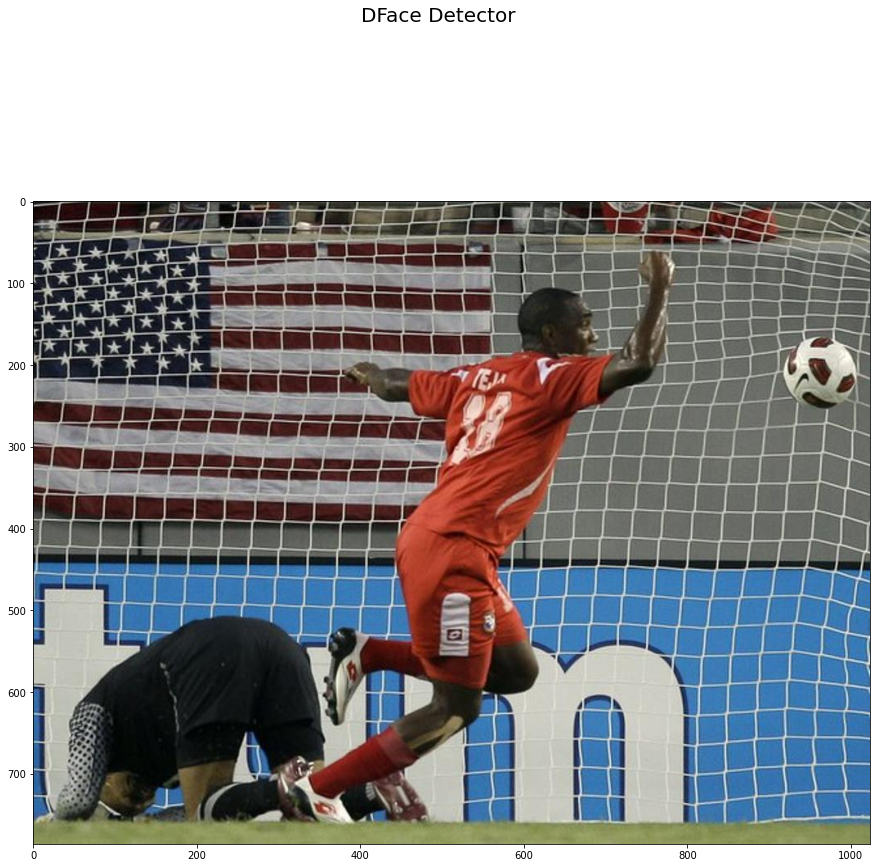

In [43]:
img = cv2.imread("/content/WIDER_val/images/12--Group/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_313.jpg")
img_bg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#b, g, r = cv2.split(img)
#img2 = cv2.merge([r, g, b])

bboxs, landmarks = mtcnn_detector.detect_face(img)
# print box_align

vis_face(img_bg,bboxs)